# Naive Bayes classifier

The first steps are the same as previously, we start up by importing libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

Defining number of points, covariance matrix and means in respective classes.

In [2]:
n = {'A': 40, 'B': 30}
cov = np.array([[4, 0], [0, 4]])
means = {'A': np.array([-3, -1]), 'B': np.array([2, 2])}

Generating the points from multivariate normal distribution and inserting them into dataframe.

In [3]:
data = pd.DataFrame(index=range(sum(n.values())), columns=['x', 'y', 'label'])
data.loc[:n['A']-1, ['x', 'y']] = np.random.multivariate_normal(means['A'], cov, n['A'])
data.loc[:n['A']-1, ['label']] = 'A'
data.loc[n['A']:, ['x', 'y']] = np.random.multivariate_normal(means['B'], cov, n['B'])
data.loc[n['A']:, ['label']] = 'B'

Function that plots the generated points.

In [4]:
def plot_points(data):
    fig = plt.figure(figsize=(8, 6))
    sns.set_style('white')
    sns.set_palette('muted')
    sns.scatterplot(data=data, x='x', y='y', hue='label', legend=False, edgecolor='black').set(xlim=(-9, 9), ylim=(-9, 9))

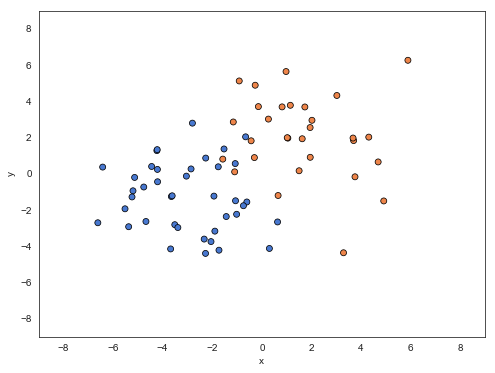

In [5]:
plot_points(data)

## Gaussian Naive Bayes model from *Scikit-learn*

We need to split our data into features and target variable. Then we create model with embedded `GaussianNB()` method and fit it according to the variables.

In [6]:
from sklearn.naive_bayes import GaussianNB

X = data[['x', 'y']]
y = data['label']
clf = GaussianNB()
clf.fit(X, y);

With `predict_proba()` method we can compute posterior probability for any point. So to plot decision boundary for two classes we will create a rectangular meshgrid out of two arrays and compute the probability in every node of the grid.

In [7]:
x_grid, y_grid = np.meshgrid(np.arange(-9, 9.1, 0.1), np.arange(-9, 9.1, 0.1))
prob = clf.predict_proba(np.c_[x_grid.ravel(), y_grid.ravel()])
prob = prob[:, 1].reshape(x_grid.shape)

Now we will define the function that plots the points with decision boundary and areas which belong to corresponding class.

In [8]:
def plot_classified_points(data, xx, yy, prob):
    plot_points(data)
    plt.contour(xx, yy, prob, [0.5], zorder=0)
    plt.contourf(xx, yy, prob, [0, 0.5, 1], cmap='Pastel2', zorder=-1)

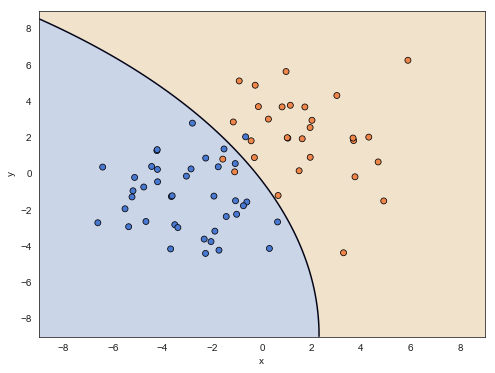

In [9]:
plot_classified_points(data, x_grid, y_grid, prob)

## Own implementation of Naive Bayes classifier

Before we start implementing the algorithm we need to update the means and covariance matrices of the generated points.

In [10]:
means = {label: np.array(np.mean(data.loc[data['label'] == label])) for label in means.keys()}
cov = {label: np.cov(data.loc[data['label'] == label][['x', 'y']].values.T.astype(float)) for label in means.keys()}

To implement our own classifier we need to make an assumption that all the features are conditionally independent to each other. With this assumption the posterior probability can be expressed by the following equation:

\begin{equation}
P(C|\boldsymbol{X}) = \frac{\pi_{C_{i}}P(\boldsymbol{X}|C_{i})}{P(\boldsymbol{X})} = \frac{\pi_{C_{i}}P(x|C_{i})P(y|C_{i})}{\pi_{C_{1}}P(x|C_{1})P(y|C_{1}) + \pi_{C_{2}}P(x|C_{2})P(y|C_{2})}
\end{equation}

where $\pi_{C_{i}}$ is the prior probability of the given class.

In [11]:
from scipy.stats import multivariate_normal

def posterior_prob(prior_prob_1, prior_prob_2, mean_1, mean_2, cov_1, cov_2, x, y):
    likelihood_x_1 = multivariate_normal.pdf(x, mean_1[0], cov_1[0, 0])
    likelihood_y_1 = multivariate_normal.pdf(y, mean_1[1], cov_1[1, 1])
    likelihood_x_2 = multivariate_normal.pdf(x, mean_2[0], cov_2[0, 0])
    likelihood_y_2 = multivariate_normal.pdf(y, mean_2[1], cov_2[1, 1])
    
    nominator = prior_prob_2 * likelihood_x_2 * likelihood_y_2
    denominator = prior_prob_1 * likelihood_x_1 * likelihood_y_1 + prior_prob_2 * likelihood_x_2 * likelihood_y_2
    
    return nominator / denominator

We estimate class prior probabilities by dividing number of class observations by total number of observations.

In [12]:
prior_prob_A = n['A'] / sum(n.values())
prior_prob_B = n['B'] / sum(n.values())

prob = posterior_prob(prior_prob_A, prior_prob_B, means['A'], means['B'], cov['A'], cov['B'], x_grid.ravel(), y_grid.ravel())
prob = prob.reshape(x_grid.shape)

Finally we can plot the decision boundary determined by our classifier.

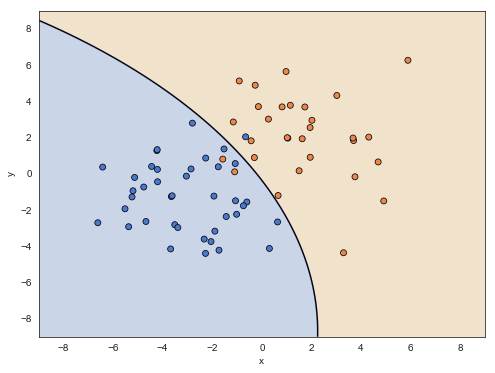

In [13]:
plot_classified_points(data, x_grid, y_grid, prob)

As we can see the results are identical both for embedded model and our own implementation.